In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#imports for k-means
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy import stats
from scipy.stats import mode
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy

from itertools import combinations

from scipy.cluster.hierarchy import fcluster

import matplotlib.cm as cm
import pickle

import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from collections import Counter
import math
import os

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, fclusterdata

from fim import apriori
from statistics import median

In [2]:
help(apriori)

Help on built-in function apriori in module fim:

apriori(...)
    apriori (tracts, target='s', supp=10, zmin=1, zmax=None, report='a',
             eval='x', agg='x', thresh=10, prune=None, algo='b', mode='',
             border=None)
    Find frequent item sets with the Apriori algorithm.
    tracts  transaction database to mine (mandatory)
            The database must be an iterable of transactions;
            each transaction must be an iterable of items;
            each item must be a hashable object.
            If the database is a dictionary, the transactions are
            the keys, the values their (integer) multiplicities.
    target  type of frequent item sets to find     (default: s)
            s/a   sets/all   all     frequent item sets
            c     closed     closed  frequent item sets
            m     maximal    maximal frequent item sets
            g     gens       generators
            r     rules      association rules
    supp    minimum support of an i

In [412]:
#Returns the list of all patterns given the val_list, support s, z_min z_ and target t
def ord_patt(val_list, s, z_, t):
    itemsets = apriori(val_list, supp=s, zmin=z_, target=t, report='as')
    print('Number of sets: %s' %len(itemsets))
    if len(itemsets) == 0:
        return None
    freqs_ord = sorted(itemsets, key=lambda x: x[2], reverse = False)
    
    return freqs_ord

#Returns the k list of most frequent patterns given the val_list, support s, z_min z_ and target t
def most_freq_patt(val_list, k, s, z_, t):
    itemsets = apriori(val_list, supp=s, zmin=z_, target=t, report='as')
    print('Number of sets: %s' %len(itemsets))
    if len(itemsets) == 0:
        return None
    freqs_ord = sorted(itemsets, key=lambda x: x[2], reverse = True)
    
    if k == 0:
        return freqs_ord
    elif len(freqs_ord) <= k:
        return freqs_ord
    else:
        return freqs_ord[0:k]

#Returns the k list of most frequent patterns given the itemsets
def most_freq_patt_from_itemsets(itemsets, k):
    if len(itemsets) == 0:
        return None
    freqs_ord = sorted(itemsets, key=lambda x: x[2], reverse = True)
    
    if k == 0:
        return freqs_ord
    elif len(freqs_ord) <= k:
        return freqs_ord
    else:
        return freqs_ord[0:k]

#Returns the dictionary {z: {target: {support: { itemsets : , n_sets : , most_freq : } } } }
def most_freq_patt_dict(val_list, k, z_max, s_min):
    dict_z = dict()
    for z_ in range(1,z_max+1):
        dict_t = dict()
        for t in ['a', 'c', 'm']:
            dict_s = dict()
            for s in range(s_min,101):
                dict_res = dict()
                itemsets = apriori(val_list, supp=s, zmin=z_, target=t, report='as')
                most_freq_list = most_freq_patt_from_itemsets(itemsets, k)
                if most_freq_list is not None:
                    dict_res.update([('itemsets', itemsets)])
                    dict_res.update([('n_sets', len(itemsets))])
                    dict_res.update([('most_freq', most_freq_list)])
                    dict_s.update([(s, dict_res)])
            dict_t.update([(t, dict_s)])

        dict_z.update([(z_, dict_t)])
    return dict_z

In [407]:
def patt_df(mfpd, s_min, z):
    data = pd.DataFrame()
    sup_range = range(s_min,101)
    data['support'] = sup_range
    for t in ['a', 'c', 'm']:
        t_list = list()
        for s in sup_range:
            if s in mfpd[z][t].keys():
                t_list.append(mfpd[z][t][s]['n_sets'])
            else:
                t_list.append(0)
        data[t] = t_list
    return data


def plot_patt(data):
    ind = np.arange(len(data))  # the x locations for the groups
    width = 0.25  # the width of the bars

    #fig, ax = plt.subplots()
    plt.figure(figsize=(15,6))
    plt.bar(ind, data['a'], width, label='a', align='center')
    plt.bar(ind + width, data['c'], width, label='c', align='center')
    plt.bar(ind + 2*width, data['m'], width, label='m', align='center')

    plt.ylabel('Number of patterns')
    #ax.set_title('Scores by group and gender')
    #plt.xticks(ind)
    #plt.xtick(range(50,101))
    plt.xticks(np.arange(len(data)), range(50,101))
    plt.xlabel('Support')
    plt.legend()

# Edit dataframe

In [4]:
cc_ = pd.read_csv('C:\\Users\\Richard\\Desktop\\DM_proj\\credit_default_FINAL.csv')

In [5]:
df = cc_.copy()
cd_ = df['credit_default']
df = df.drop(columns=['credit_default'])
df.insert(loc=0, column='credit_default', value=cd_)
df.head()

,credit_default,limit,sex,education,status,age,ps-sep,ps-aug,ps-jul,ps-jun,...,ba-jul,ba-jun,ba-may,ba-apr,pa-sep,pa-aug,pa-jul,pa-jun,pa-may,pa-apr
0,no,50000,male,graduate school,single,25.0,2,0,0,0,...,50760,49535,30358,30302,2130,1905,1811,1100,1100,1200
1,no,200000,male,university,married,54.0,-1,-1,-1,-1,...,7843,6335,4616,7956,10120,7852,6336,4622,7956,5499
2,no,30000,female,high school,married,41.0,2,3,2,2,...,30206,30496,29731,29047,0,1700,1100,3,1053,1303
3,no,140000,female,university,single,28.0,0,0,0,0,...,42823,25224,26855,23783,2000,2000,900,2000,10000,5000
4,yes,60000,female,high school,married,36.0,1,2,2,0,...,47632,48738,49601,52773,1788,0,1894,1801,3997,0


In [6]:
df['ageBin'] = pd.cut(df['age'].astype(int), 10, right=False)
df['limitBin'] = pd.cut(df['limit'].astype(int), 30, right=False)

att_list = [a+'-'+b for a in ['ba', 'pa'] for b in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']]
for l in att_list:
    df[l+'Bin'] = pd.cut(df[l].astype(int), 30, right=False)

df.drop(['age', 'limit'], axis=1, inplace=True)
df.drop(att_list, axis=1, inplace=True)
df.head()

,credit_default,sex,education,status,ps-sep,ps-aug,ps-jul,ps-jun,ps-may,ps-apr,...,ba-junBin,ba-julBin,ba-augBin,ba-sepBin,pa-aprBin,pa-mayBin,pa-junBin,pa-julBin,pa-augBin,pa-sepBin
0,no,male,graduate school,single,2,0,0,0,0,0,...,"[39810.9, 61182.2)","[48314.167, 70278.2)","[42843.0, 65367.0)","[48438.6, 69380.133)","[0.0, 14766.7)","[0.0, 10117.067)","[0.0, 9765.4)","[0.0, 13919.6)","[0.0, 12937.533)","[0.0, 10767.133)"
1,no,male,university,married,-1,-1,-1,-1,-1,-1,...,"[-2931.7, 18439.6)","[4386.1, 26350.133)","[-2205.0, 20319.0)","[6555.533, 27497.067)","[0.0, 14766.7)","[0.0, 10117.067)","[0.0, 9765.4)","[0.0, 13919.6)","[0.0, 12937.533)","[0.0, 10767.133)"
2,no,female,high school,married,2,3,2,2,2,0,...,"[18439.6, 39810.9)","[26350.133, 48314.167)","[20319.0, 42843.0)","[27497.067, 48438.6)","[0.0, 14766.7)","[0.0, 10117.067)","[0.0, 9765.4)","[0.0, 13919.6)","[0.0, 12937.533)","[0.0, 10767.133)"
3,no,female,university,single,0,0,0,0,0,0,...,"[18439.6, 39810.9)","[26350.133, 48314.167)","[20319.0, 42843.0)","[48438.6, 69380.133)","[0.0, 14766.7)","[0.0, 10117.067)","[0.0, 9765.4)","[0.0, 13919.6)","[0.0, 12937.533)","[0.0, 10767.133)"
4,yes,female,high school,married,1,2,2,0,0,0,...,"[39810.9, 61182.2)","[26350.133, 48314.167)","[42843.0, 65367.0)","[27497.067, 48438.6)","[0.0, 14766.7)","[0.0, 10117.067)","[0.0, 9765.4)","[0.0, 13919.6)","[0.0, 12937.533)","[0.0, 10767.133)"


In [7]:
for l in [a+'-'+b for a in ['ps'] for b in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']]:
    df[l] = df[l].astype(str) + '_' + l

for l in [a+'-'+b for a in ['ba', 'pa'] for b in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']]:
    df[l+'Bin'] = df[l+'Bin'].astype(str) + '_' + l
    
df['limitBin'] = df['limitBin'].astype(str) + '_limit'
df['ageBin'] = df['ageBin'].astype(str) + '_age'

df.head()

,credit_default,sex,education,status,ps-sep,ps-aug,ps-jul,ps-jun,ps-may,ps-apr,...,ba-junBin,ba-julBin,ba-augBin,ba-sepBin,pa-aprBin,pa-mayBin,pa-junBin,pa-julBin,pa-augBin,pa-sepBin
0,no,male,graduate school,single,2_ps-sep,0_ps-aug,0_ps-jul,0_ps-jun,0_ps-may,0_ps-apr,...,"[39810.9, 61182.2)_ba-jun","[48314.167, 70278.2)_ba-jul","[42843.0, 65367.0)_ba-aug","[48438.6, 69380.133)_ba-sep","[0.0, 14766.7)_pa-apr","[0.0, 10117.067)_pa-may","[0.0, 9765.4)_pa-jun","[0.0, 13919.6)_pa-jul","[0.0, 12937.533)_pa-aug","[0.0, 10767.133)_pa-sep"
1,no,male,university,married,-1_ps-sep,-1_ps-aug,-1_ps-jul,-1_ps-jun,-1_ps-may,-1_ps-apr,...,"[-2931.7, 18439.6)_ba-jun","[4386.1, 26350.133)_ba-jul","[-2205.0, 20319.0)_ba-aug","[6555.533, 27497.067)_ba-sep","[0.0, 14766.7)_pa-apr","[0.0, 10117.067)_pa-may","[0.0, 9765.4)_pa-jun","[0.0, 13919.6)_pa-jul","[0.0, 12937.533)_pa-aug","[0.0, 10767.133)_pa-sep"
2,no,female,high school,married,2_ps-sep,3_ps-aug,2_ps-jul,2_ps-jun,2_ps-may,0_ps-apr,...,"[18439.6, 39810.9)_ba-jun","[26350.133, 48314.167)_ba-jul","[20319.0, 42843.0)_ba-aug","[27497.067, 48438.6)_ba-sep","[0.0, 14766.7)_pa-apr","[0.0, 10117.067)_pa-may","[0.0, 9765.4)_pa-jun","[0.0, 13919.6)_pa-jul","[0.0, 12937.533)_pa-aug","[0.0, 10767.133)_pa-sep"
3,no,female,university,single,0_ps-sep,0_ps-aug,0_ps-jul,0_ps-jun,0_ps-may,0_ps-apr,...,"[18439.6, 39810.9)_ba-jun","[26350.133, 48314.167)_ba-jul","[20319.0, 42843.0)_ba-aug","[48438.6, 69380.133)_ba-sep","[0.0, 14766.7)_pa-apr","[0.0, 10117.067)_pa-may","[0.0, 9765.4)_pa-jun","[0.0, 13919.6)_pa-jul","[0.0, 12937.533)_pa-aug","[0.0, 10767.133)_pa-sep"
4,yes,female,high school,married,1_ps-sep,2_ps-aug,2_ps-jul,0_ps-jun,0_ps-may,0_ps-apr,...,"[39810.9, 61182.2)_ba-jun","[26350.133, 48314.167)_ba-jul","[42843.0, 65367.0)_ba-aug","[27497.067, 48438.6)_ba-sep","[0.0, 14766.7)_pa-apr","[0.0, 10117.067)_pa-may","[0.0, 9765.4)_pa-jun","[0.0, 13919.6)_pa-jul","[0.0, 12937.533)_pa-aug","[0.0, 10767.133)_pa-sep"


# Patterns

In [8]:
val_list = df.values.tolist()

In [403]:
#itemsets = apriori(val_list, supp=85, zmin=2, target='a', report='as')

In [410]:
most_freq_patt(val_list, 5, 85, 2, 'c')

Number of sets: 15


[(('[0.0, 13919.6)_pa-jul', '[0.0, 14766.7)_pa-apr'),
  8903,
  0.8929789368104313),
 (('[0.0, 10117.067)_pa-may', '[0.0, 14766.7)_pa-apr'),
  8812,
  0.883851554663992),
 (('[0.0, 12937.533)_pa-aug', '[0.0, 14766.7)_pa-apr'),
  8805,
  0.8831494483450351),
 (('[0.0, 12937.533)_pa-aug', '[0.0, 13919.6)_pa-jul'),
  8795,
  0.8821464393179539),
 (('[0.0, 10117.067)_pa-may', '[0.0, 13919.6)_pa-jul'),
  8752,
  0.8778335005015045)]

In [411]:
#op_a = ord_patt(val_list, 10, 1, 'a')

In [111]:
most_freq_patt(val_list, 5, 8, 1, 'a')

Number of sets: 21


[(('[0.0, 14766.7)_pa-apr',), 9379, 0.9407221664994985),
 (('[0.0, 13919.6)_pa-jul',), 9315, 0.9343029087261785),
 (('[0.0, 12937.533)_pa-aug',), 9190, 0.921765295887663),
 (('[0.0, 10117.067)_pa-may',), 9177, 0.9204613841524574),
 (('[0.0, 10767.133)_pa-sep',), 9019, 0.9046138415245737)]

In [379]:
mfpd = most_freq_patt_dict(val_list, 5, 2, 45)

In [405]:
df_pat = patt_df(mfpd, 50, 1)

In [406]:
df_pat.head()

,support,a,c,m
0,50,189,189,34
1,51,171,171,24
2,52,159,159,21
3,53,147,147,13
4,54,141,141,10


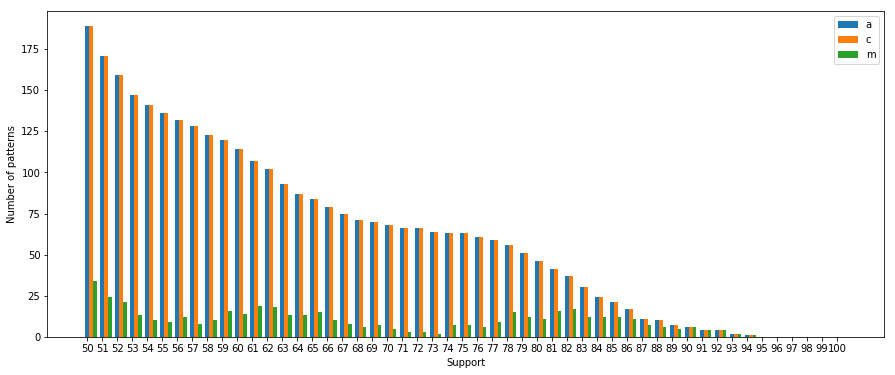

In [408]:
plot_patt(df_pat)

# Association rules - ancora da vedere ↓

In [153]:
rules = apriori(val_list, supp=2, zmin=2, target='r', conf=60, report='ascl') 
print('Number of rule:', len(rules))
rules[0]

Number of rule: 7145150


('0_ps-sep',
 ('5000_pa-sep', '0_ps-aug'),
 193,
 0.019358074222668005,
 0.9146919431279621,
 1.8737371425900518)

In [154]:
l = []
for r in rules:
    l.append(r[0])

cnt_rul = Counter(l)
print('yes = %s - no = %s' %(cnt_rul['yes'], cnt_rul['no']))
#cnt_rul

yes = 232 - no = 506039


In [18]:
def ass_rule(itmset, max_s, conf_, report_):
    d_ret = dict()
    d_ret.update([('conf', conf_)])
    #d_ret.update([('target', target)])
    for s in range(9, max_s):
        d_int = dict()
        rules = apriori(itmset, supp=s, zmin=2, target='r', conf=conf_, report=report_) 
        numRules= len(rules)
        if (numRules == 0):
            break
        #print('Supp: ', s, ' Conf: '+ conf_ + ' Number of rules:', len(rules), end='')
        
        cnt_rul = Counter([r[0] for r in rules])
        #print(' -> yes = %s - no = %s' %(cnt_rul['yes'], cnt_rul['no']))
        
        d_int.update([('itemsets', itmset)])
        d_int.update([('rules', rules)])
        d_int.update([('numRules', numRules)])
        d_int.update([('yes', cnt_rul['yes'])])
        d_int.update([('no', cnt_rul['no'])])
        d_ret.update([(s, d_int)])
    
    return d_ret

In [31]:
ass_1 = ass_rule(val_list, 10, 60, 'ascl')

In [23]:
ass_1[9]['no']

154811